In [1]:
# Importar las librerías
from binance.client import Client
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Introducir datos de API
client = Client()

In [3]:
# Definir una función para obtener datos históricos
def get_historical_klines(symbol, interval, start, end):
    """
    Obtiene datos históricos de precios de Binance.

    :param symbol: Símbolo de la criptomoneda, ej. 'BTCUSDT'
    :param interval: Intervalo de tiempo, ej. '1d' para diario
    :param start: Fecha de inicio en formato 'dd/mm/yyyy'
    :param end: Fecha de fin en formato 'dd/mm/yyyy'
    :return: DataFrame con los datos de precios históricos
    """
    klines = client.get_historical_klines(symbol, interval, start, end)
    data = pd.DataFrame(klines, columns =[
        'timestamp',
        'open',
        'high',
        'low',
        'close',
        'volume',
        'close_time',
        'quote_asset_volume',
        'number_of_trades',
        'taker_buy_base_asset_volume',
        'taker_buy_quote,asset_volume',
        'ignore'
    ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit = 'ms')
    data.set_index('timestamp', inplace = True)
    return data[['open', 'high', 'low', 'close', 'volume']].astype(float)

In [4]:
# Definir las fechas de inicio y fin
start_date = '01/01/2020'
end_date = datetime.datetime.today().strftime('%d/%m/%Y')

In [5]:
# Obtener datos históricos
btc_data = get_historical_klines('BTCUSDT', Client.KLINE_INTERVAL_1DAY, start_date, end_date)
eth_data = get_historical_klines('ETHUSDT', Client.KLINE_INTERVAL_1DAY, start_date, end_date)
sol_data = get_historical_klines('SOLUSDT', Client.KLINE_INTERVAL_1DAY, start_date, end_date)

In [6]:
# Guardamos los datos
btc_data.to_csv('btc_data.csv')
eth_data.to_csv('eth_data.csv')
sol_data.to_csv('sol_data.csv')

### Comprobación

In [7]:
btc_data = pd.read_csv('btc_data.csv', index_col = 'timestamp', parse_dates = True)
eth_data = pd.read_csv('eth_data.csv', index_col = 'timestamp', parse_dates = True)
sol_data = pd.read_csv('sol_data.csv', index_col = 'timestamp', parse_dates = True)

In [8]:
btc_data.head()

,open,high,low,close,volume
timestamp,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604


In [9]:
eth_data.head()

,open,high,low,close,volume
timestamp,,,,,
2020-01-01,129.16,133.05,128.68,130.77,144770.52197
2020-01-02,130.72,130.78,126.38,127.19,213757.05806
2020-01-03,127.19,135.14,125.88,134.35,413055.18895
2020-01-04,134.37,135.85,132.50,134.20,184276.17102
2020-01-05,134.20,138.19,134.19,135.37,254120.45343


In [10]:
sol_data.head()

,open,high,low,close,volume
timestamp,,,,,
2020-08-11,2.8500,3.5208,2.8433,3.2985,1552384.78
2020-08-12,3.2985,3.9289,3.0800,3.7558,1737042.95
2020-08-13,3.7500,4.1387,3.5003,3.7300,1685759.24
2020-08-14,3.7207,3.7676,3.3210,3.4099,1474161.79
2020-08-15,3.4181,3.7400,3.1500,3.1730,1070233.20


# EDA

In [11]:
# Parece que todos los datos están correctos, toca verificar los valores nulos
btc_data.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [12]:
eth_data.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [13]:
sol_data.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Normalización de Datos

In [14]:
# Función de normalización
def normalize(data):
    return (data- data.min()) / (data.max() - data.min())

In [15]:
# Aplicar normalización
def create_preprocessing_pipeline():
    return Pipeline([
        ('scaler', MinMaxScaler())
    ])


In [16]:
# Aplicar el Pipeline a los datos
pipeline = create_preprocessing_pipeline()

btc_data_normalized = pipeline.fit_transform(btc_data)
eth_data_normalized = pipeline.fit_transform(eth_data)
sol_data_normalized = pipeline.fit_transform(sol_data)

In [22]:
# Convertir los datos normalizados de vuelta al DataFrame
btc_data_normalized = pd.DataFrame(pipeline.fit_transform(btc_data), columns=btc_data.columns, index=btc_data.index)
eth_data_normalized = pd.DataFrame(pipeline.fit_transform(eth_data), columns=eth_data.columns, index=eth_data.index)
sol_data_normalized = pd.DataFrame(pipeline.fit_transform(sol_data), columns=sol_data.columns, index=sol_data.index)

In [23]:
# División de los datos en conjuntos de entrenamiento y prueba
btc_train, btc_test = train_test_split(btc_data_normalized, test_size = 0.2, shuffle = False)
eth_train, eth_test = train_test_split(eth_data_normalized, test_size = 0.2, shuffle = False)
sol_train, sol_test = train_test_split(sol_data_normalized, test_size = 0.2, shuffle = False)

In [24]:
# Extraer y guardar las fechas justo después de la división
btc_test_dates = btc_test.index
eth_test_dates = eth_test.index
sol_test_dates = sol_test.index

### LSTM

In [26]:
# Convertir las series temporales en matrices de entrada para LSTM
def create_dataset(data, look_back = 1):
    X, Y = [], []
    for i in range (len(data) - look_back - 1):
        a = data.iloc[i: (i + look_back), :]
        X.append(a)
        Y.append(data.iloc[(i + look_back), 3]) # Recordar que la columna 3 corresponde a 'close'
    return np.array(X), np.array(Y)

look_back = 10
X_btc_train, Y_btc_train = create_dataset(btc_train, look_back)
X_btc_test, Y_btc_test = create_dataset(btc_test, look_back)

X_eth_train, Y_eth_train = create_dataset(eth_train, look_back)
X_eth_test, Y_eth_test = create_dataset(eth_test, look_back)

X_sol_train, Y_sol_train = create_dataset(sol_train, look_back)
X_sol_test, Y_sol_test = create_dataset(sol_test, look_back)

In [27]:
# Definir y compilar el LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences = True, input_shape=input_shape))
    model.add(LSTM(units = 50, return_sequences = False))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return model

In [28]:
# Definir la forma de entrada basada en el conjunto de datos de entrenamiento
input_shape = (look_back, X_btc_train.shape[2])

In [29]:
# Crear el modelo para Bitcoin
btc_model = create_lstm_model(input_shape)

c:\Users\fprada\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Entrenar el modelo para Bitcoin
btc_model.fit(X_btc_train, Y_btc_train, batch_size = 1, epochs = 10)

# Repetir para Ethereum y Solana
eth_model = create_lstm_model(input_shape)
eth_model.fit(X_eth_train, Y_eth_train, batch_size = 1, epochs = 10)

sol_model = create_lstm_model(input_shape)
sol_model.fit(X_sol_train, Y_sol_train, batch_size = 1, epochs = 10)

Epoch 1/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0039
Epoch 2/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0014
Epoch 3/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0010
Epoch 4/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.2229e-04
Epoch 5/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.4968e-04
Epoch 6/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.3942e-04
Epoch 7/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.2220e-04
Epoch 8/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.9563e-04
Epoch 9/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.8402e-04
Epoch 10/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 6.2137e-04
Epoch 1/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0058
Epoch 2/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0019
Epoch 3/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0011
Epoch 4/10
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0011
Epoch

In [31]:
# Evaluar el modelo
def evaluate_model(model, X_test, Y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(Y_test, predictions)
    mae = mean_absolute_error(Y_test, predictions)
    return predictions, mse, mae

In [32]:
# Evaluar el modelo para Bitcoin
btc_predictions, btc_mse, btc_mae = evaluate_model(btc_model, X_btc_test, Y_btc_test)
print(f'Bitcoin - MSE: {btc_mse}, MAE: {btc_mae}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Bitcoin - MSE: 0.0005326009831232227, MAE: 0.01580388109480669


In [33]:
# Evaluar el modelo para Ethereum
eth_predictions, eth_mse, eth_mae = evaluate_model(eth_model, X_eth_test, Y_eth_test)
print(f'Ethereum - MSE: {eth_mse}, MAE: {eth_mae}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Ethereum - MSE: 0.0004986738688917084, MAE: 0.015232494571956579


In [34]:
# Evaluar el modelo para Solana
sol_predictions, sol_mse, sol_mae = evaluate_model(sol_model, X_sol_test, Y_sol_test)
print(f'Solana - MSE: {sol_mse}, MAE: {sol_mae}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Solana - MSE: 0.001554474294805067, MAE: 0.031139539414799945


### Visualización de resultados

In [35]:
def plot_predictions(Y_test, predictions, title):
    plt.figure(figsize = (12,6))
    plt.plot(Y_test, label = 'Actual Price')
    plt.plot(predictions, label = 'Predicted Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

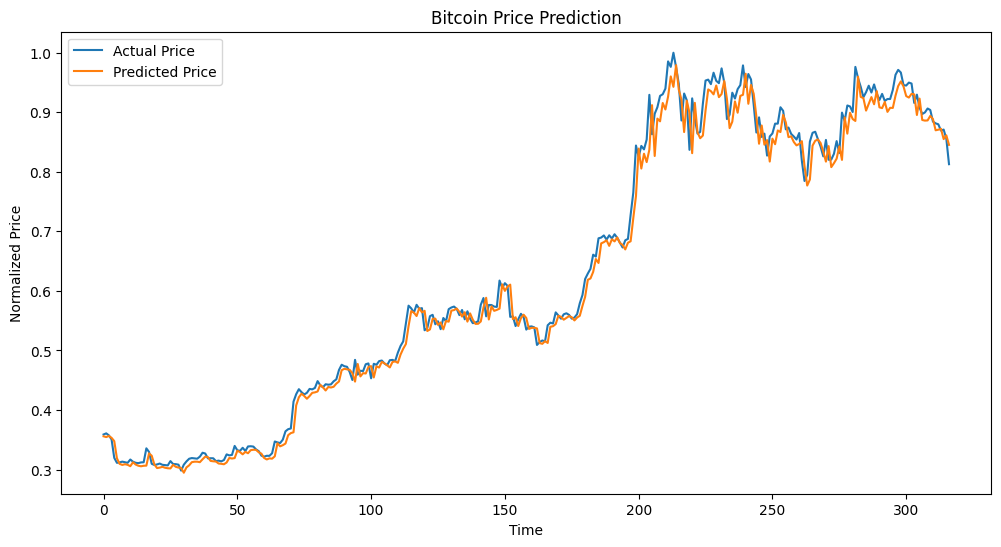

In [36]:
# Visualizar predicciones para Bitcoin
plot_predictions(Y_btc_test, btc_predictions, 'Bitcoin Price Prediction')

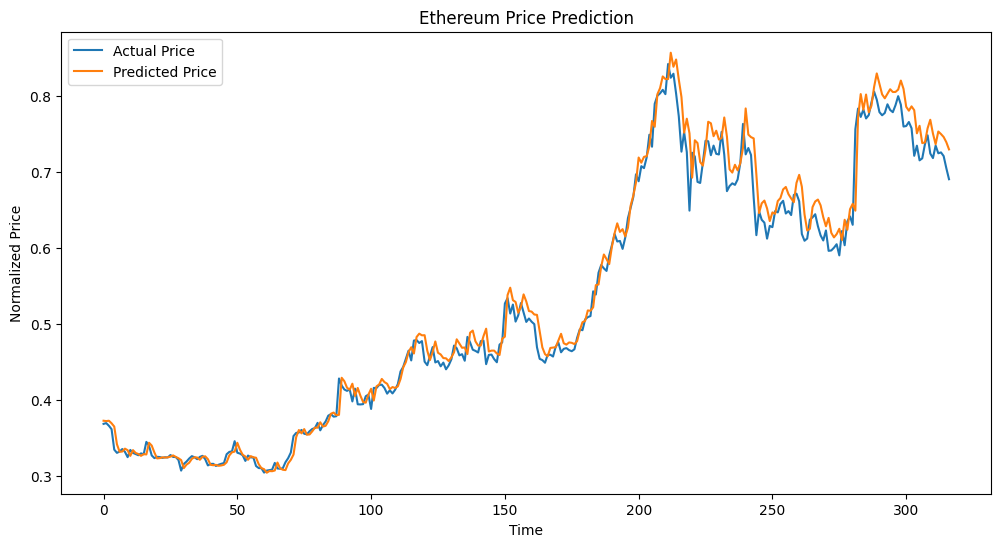

In [37]:
# Visualizar predicciones para Ethereum
plot_predictions(Y_eth_test, eth_predictions, 'Ethereum Price Prediction')

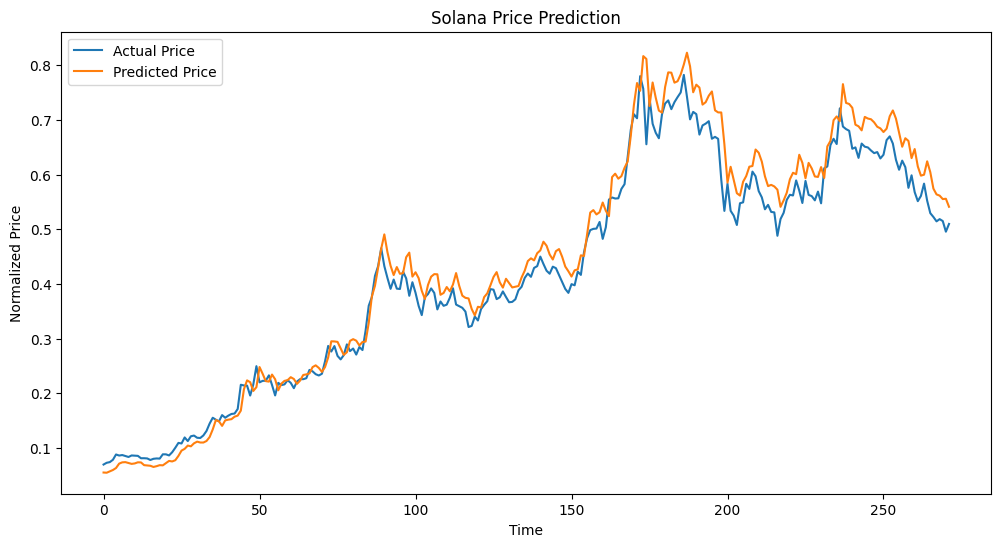

In [38]:
# Visualizar predicciones para Solana
plot_predictions(Y_sol_test, sol_predictions, 'Solana Price Prediction')

### Desnormalización

Se preocede a desnormalizar los datos para que los gráficos sean mas claros y entendibles.

In [39]:
# Obtener el scaler ajustado
btc_scaler = pipeline.named_steps['scaler']
eth_scaler = pipeline.named_steps['scaler']
sol_scaler = pipeline.named_steps['scaler']

In [40]:
# Obtener los valores de min y max
btc_min = btc_scaler.data_min_[3] # Recordar que el índice 3 corresponde a 'close'
btc_max = btc_scaler.data_max_[3]

eth_min = eth_scaler.data_min_[3]
eth_max = eth_scaler.data_max_[3]

sol_min = sol_scaler.data_min_[3]
sol_max = sol_scaler.data_max_[3]

In [41]:
# Función para desnormalizar datos
def denormalize(values, data_min, data_max):
    return values * (data_max - data_min) + data_min

In [42]:
# Desnormalizar los datos
Y_btc_test_denorm = denormalize(Y_btc_test, btc_min, btc_max)
btc_predictions_denorm = denormalize(btc_predictions, btc_min, btc_max)

Y_eth_test_denorm = denormalize(Y_eth_test, eth_min, eth_max)
eth_predictions_denorm = denormalize(eth_predictions, eth_min, eth_max)

Y_sol_test_denorm = denormalize(Y_sol_test, sol_min, sol_max)
sol_predictions_denorm = denormalize(sol_predictions, sol_min, sol_max)

### Visualización sin normalización

In [43]:
def plot_predictions_with_dates(dates, Y_test, predictions, title):
    plt.figure(figsize=(12,6))
    plt.plot(dates, Y_test, label = 'Actual Price')
    plt.plot(dates, predictions, label = 'Predicted Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [44]:
# Obtener las fehcas correspondientes
btc_dates = btc_test_dates[look_back+1:]
eth_dates = eth_test_dates[look_back+1:]
sol_dates = sol_test_dates[look_back+1:]

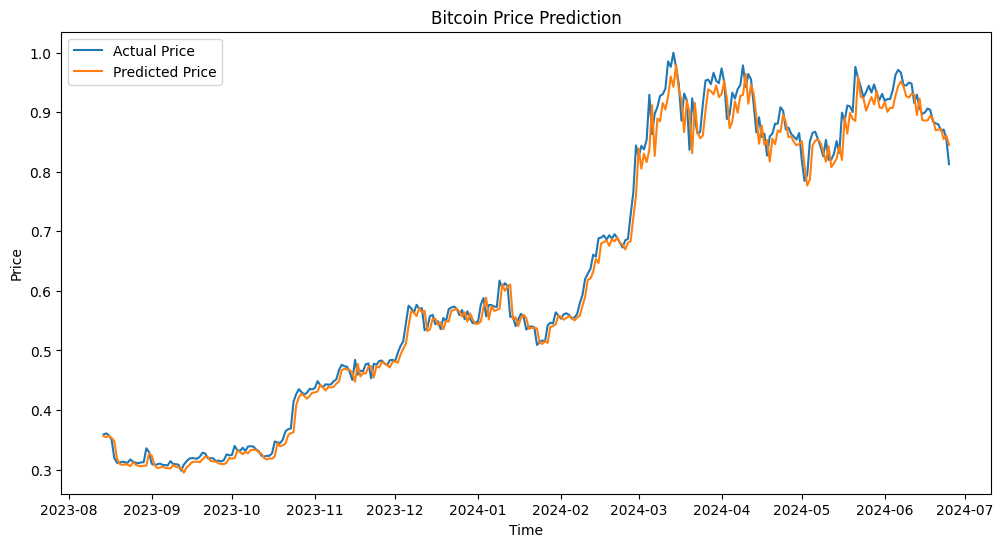

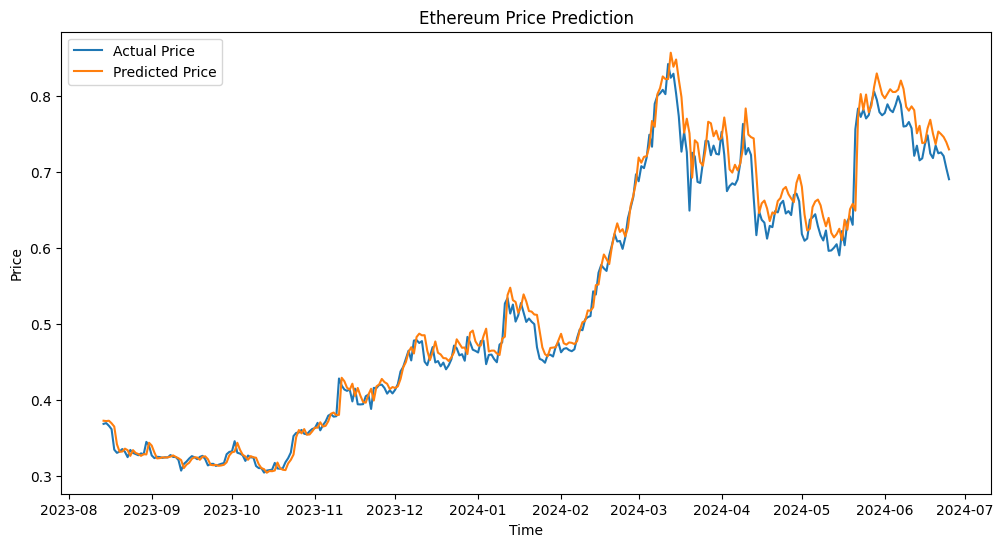

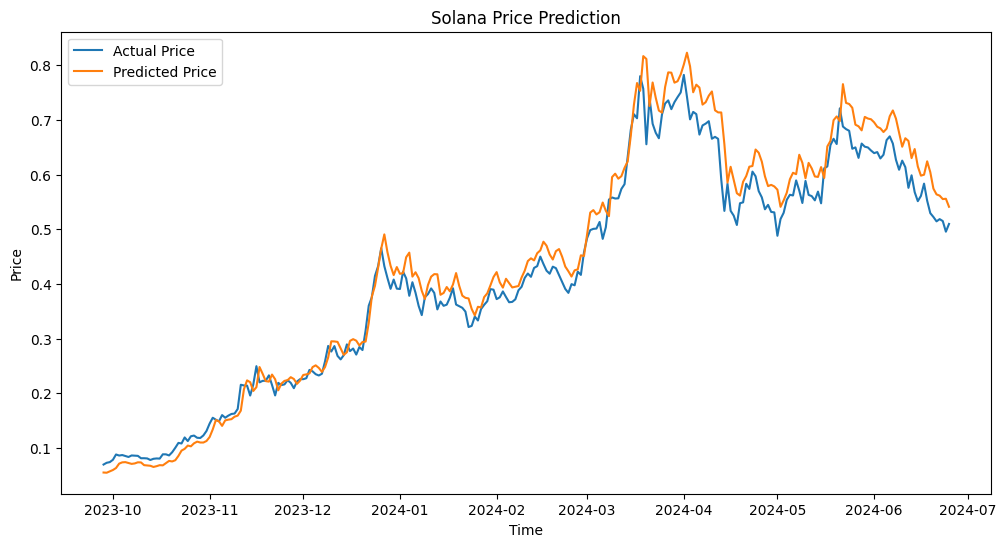

In [45]:
# Visualizar las predicciones
plot_predictions_with_dates(btc_dates, Y_btc_test_denorm, btc_predictions_denorm, 'Bitcoin Price Prediction')

plot_predictions_with_dates(eth_dates, Y_eth_test_denorm, eth_predictions_denorm, 'Ethereum Price Prediction')

plot_predictions_with_dates(sol_dates, Y_sol_test_denorm, sol_predictions_denorm, 'Solana Price Prediction')